## 모델링을 위한 기본 전처리
- 목적
    - 모델링을 위한 기본 전처리하기
- 핵심
    - SQL(BigQuery)로 가능한 부분은 SQL에서 => 로컬 파이썬 보다 좋은 성능일 수 있음. 단, 데이터 IO도 생각해야 함
    - SQL에서 힘든 전처리는 Python에서! => Label Encoding, One Hot Encoding 등
- 다루는 내용
    - `시간 관련 전처리`
        - DATETIME에서 MONTH, HOUR, WEEKDAY 등 추출
        - BigQuery vs Python
    - `BigQuery GIS`로 Reverse Engineering
        - 좌표 => zip_code로 변환
    - `Categorical 데이터 전처리`
        - One Hot Encoding
        - Label Encoding
    - `Train / Test Split`

In [45]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import warnings
import seaborn as sns
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

### 시간 관련 전처리
- 1) BigQuery에서 처리하기
    - DATETIME_TRUNC : 데이터 자르기
    - EXTRACT 함수를 사용하면 MONTH, WEEK, DAY, HOUR 등을 쉽게 추출 가능 
        - [EXTRACT 공식 문서](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions?hl=ko#extract)
    - FORMAT_DATETIME 함수를 사용하면 요일을 추출할 수 있음(단, 1이 월요일 => Pandas에선 0이 월요일)
        - [FORMAT_DATETIME 공식 문서](https://cloud.google.com/bigquery/docs/reference/standard-sql/datetime_functions?hl=ko#format_datetime)

In [5]:
%%time
extract_query = """
SELECT
    *,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday, # Python과 맞추기 위해 -1
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (5, 6) THEN 1 ELSE 0 END AS is_weekend
FROM (
    SELECT 
        DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
        count(*) AS cnt
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
    WHERE EXTRACT(MONTH from pickup_datetime) = 1
    GROUP BY pickup_hour
)
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=extract_query, dialect='standard', project_id='geultto')

CPU times: user 67.8 ms, sys: 5.39 ms, total: 73.1 ms
Wall time: 2.06 s


In [6]:
df.tail()

,pickup_hour,cnt,month,day,weekday,hour,is_weekend
739,2015-01-31 19:00:00,32436,1,31,5,19,1
740,2015-01-31 20:00:00,27555,1,31,5,20,1
741,2015-01-31 21:00:00,27477,1,31,5,21,1
742,2015-01-31 22:00:00,29862,1,31,5,22,1
743,2015-01-31 23:00:00,29856,1,31,5,23,1


- 또는 아래 쿼리도 가능
    - 단, 현재 1시간 단위로 해서 아래 쿼리도 가능한 것이고 30분 단위로 나눈다고 하면 분을 조정해야 함
    - 예 : 14시 35분 => 14시 30분 이런식으로

In [7]:
%%time
extract_query = """
SELECT 
    DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) -1 AS weekday, # Python과 맞추기 위해 -1
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (5, 6) THEN 1 ELSE 0 END AS is_weekend,
    count(*) AS cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=extract_query, dialect='standard', project_id='geultto')

CPU times: user 82.2 ms, sys: 6.16 ms, total: 88.4 ms
Wall time: 9.19 s


In [9]:
df.tail()

,pickup_hour,month,day,weekday,hour,is_weekend,cnt
739,2015-01-31 19:00:00,1,31,5,19,1,32436
740,2015-01-31 20:00:00,1,31,5,20,1,27555
741,2015-01-31 21:00:00,1,31,5,21,1,27477
742,2015-01-31 22:00:00,1,31,5,22,1,29862
743,2015-01-31 23:00:00,1,31,5,23,1,29856


- 2) Python에서 처리하기
    - Pandas datetime 처리하기
    - `pd.to_datetime`으로 datetime 변환 후, df[col].dt.xxx 로 추출

In [10]:
extract_query = """
SELECT 
    DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
    count(*) AS cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=extract_query, dialect='standard', project_id='geultto')

In [11]:
df.head()

,pickup_hour,cnt
0,2015-01-01 00:00:00,28312
1,2015-01-01 01:00:00,31707
2,2015-01-01 02:00:00,28068
3,2015-01-01 03:00:00,24288
4,2015-01-01 04:00:00,17081


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
pickup_hour    744 non-null datetime64[ns]
cnt            744 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.7 KB


- pickup_hour가 daettime64이라 to_datetime하지 않아도 날짜 관련 데이터 추출 가능
    - 만약 다른 형태로 되어 있다면 `pd.to_datetime(df['pickup_hour'])`로 변환

In [13]:
df['month'] = df['pickup_hour'].dt.month
df['day'] = df['pickup_hour'].dt.day
df['weekday'] = df['pickup_hour'].dt.weekday
df['hour'] = df['pickup_hour'].dt.hour
df['is_weekend'] = (df['pickup_hour'].dt.weekday // 5 == 1).astype(int)

In [14]:
df.tail()

,pickup_hour,cnt,month,day,weekday,hour,is_weekend
739,2015-01-31 19:00:00,32436,1,31,5,19,1
740,2015-01-31 20:00:00,27555,1,31,5,20,1
741,2015-01-31 21:00:00,27477,1,31,5,21,1
742,2015-01-31 22:00:00,29862,1,31,5,22,1
743,2015-01-31 23:00:00,29856,1,31,5,23,1


- 정리 : SQL(BigQuery)로 가능한 부분은 SQL에서 => 로컬 파이썬 보다 좋은 성능일 수 있음. 단, 데이터 IO도 생각해야 함


In [15]:
df.head(3)

,pickup_hour,cnt,month,day,weekday,hour,is_weekend
0,2015-01-01 00:00:00,28312,1,1,3,0,0
1,2015-01-01 01:00:00,31707,1,1,3,1,0
2,2015-01-01 02:00:00,28068,1,1,3,2,0


### `BigQuery GIS`로 Reverse Engineering
- 좌표 => zip_code로 변환
- BigQuery의 `bigquery-public-data.geo_us_boundaries.zip_codes` 참고
- ST_CONTAINS 함수로 추출 가능

In [16]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (5, 6) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id='geultto')

CPU times: user 3.58 s, sys: 289 ms, total: 3.86 s
Wall time: 30.8 s


In [17]:
base_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,cnt
87015,11374,2015-01-31 23:00:00,1,31,5,23,3
87016,10162,2015-01-31 23:00:00,1,31,5,23,3
87017,11370,2015-01-31 23:00:00,1,31,5,23,1
87018,10011,2015-01-31 23:00:00,1,31,5,23,1797
87019,11208,2015-01-31 23:00:00,1,31,5,23,1


### `Categorical 데이터 전처리`
- One Hot Encoding

In [18]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [19]:
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
oh_feature_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+enc.categories_[0])], axis=1)
oh_feature_df.head(3)

,zip_code,pickup_hour,month,day,weekday,hour,cnt,zip_code_10001,zip_code_10002,zip_code_10003,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,11237,2015-01-01,1,1,3,0,38,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10456,2015-01-01,1,1,3,0,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10103,2015-01-01,1,1,3,0,31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Label Encoding

In [20]:
# le = LabelEncoder()
# le.fit(base_df['zip_code'])
# base_df['zip_code_le'] = le.transform(base_df['zip_code'])

- 여기선 One Hot Encoding을 사용하겠습니다 :)

### Train and Test Split
- 시계열 데이터는 Random Sampling을 하면 안됨
- Train엔 과거 데이터, Test엔 (과거 대비) 미래 데이터가 있어야 함
    - 만약 Train에 미래 데이터가 있다면? 미래를 보고 과거를 예측한 꼴
    - 실제로 사용할 땐 과거 데이터 기반으로 미래 데이터를 예측

In [21]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

- 위 방법은 명시적으로 date를 지정하는 방법이 마음에 들지 않을수도 있음
    - 이럴 경우 Dataframe의 시간 데이터를 마지막 1주치만 Test로 지정할 수 있음

In [22]:
def split_train_and_test_period(df, period):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    period : train/test 기준 일
    """
    criteria = (max(df['pickup_hour']) - pd.Timedelta(days=period)).date()
    train_df = df[df['pickup_hour'] < criteria]
    test_df = df[df['pickup_hour'] >= criteria]
    return train_df, test_df

### Linear Regerssion
- Baseline 모델
    - 작업한 모델 중 제일 성능이 낮을 모델, 비교 대상 

In [24]:
oh_feature_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,cnt,zip_code_10001,zip_code_10002,zip_code_10003,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,11237,2015-01-01,1,1,3,0,38,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10456,2015-01-01,1,1,3,0,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10103,2015-01-01,1,1,3,0,31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11215,2015-01-01,1,1,3,0,97,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10162,2015-01-01,1,1,3,0,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


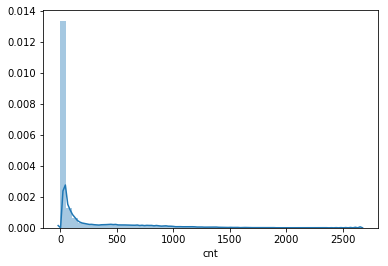

In [28]:
sns.distplot(oh_feature_df['cnt']);

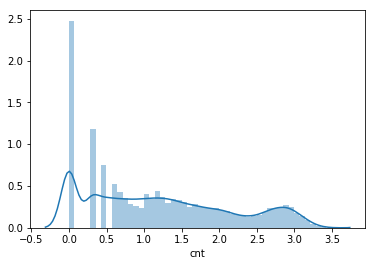

In [29]:
sns.distplot(np.log10(oh_feature_df['cnt']));

In [30]:
oh_feature_df['log_cnt'] = np.log10(oh_feature_df['cnt'])

### Train / Test 나누기

In [ ]:
# def split_train_and_test(df):
#     train_df = df[df['pickup_hour'] <'2015-01-24']
#     test_df = df[df['pickup_hour'] >='2015-01-24']
#     return train_df, test_df

In [31]:
train_df, test_df = split_train_and_test(oh_feature_df, '2015-01-24')

In [32]:
train_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,cnt,zip_code_10001,zip_code_10002,zip_code_10003,...,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,log_cnt
0,11237,2015-01-01,1,1,3,0,38,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.579784
1,10456,2015-01-01,1,1,3,0,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.778151
2,10103,2015-01-01,1,1,3,0,31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.491362
3,11215,2015-01-01,1,1,3,0,97,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.986772
4,10162,2015-01-01,1,1,3,0,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.778151


In [33]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']
# del train_df['zip_code_le']
# del test_df['zip_code_le']

In [34]:
train_df.head(2)

,month,day,weekday,hour,cnt,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,log_cnt
0,1,1,3,0,38,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.579784
1,1,1,3,0,6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.778151


In [35]:
y_train = train_df.pop('log_cnt')
x_train = train_df.copy()

In [37]:
y_test = test_df.pop('log_cnt')
x_test = test_df.copy()

In [40]:
real_train_y = x_train['cnt']
real_test_y = x_test['cnt']

In [41]:
del x_train['cnt']
del x_test['cnt']

In [46]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
pred = lr_reg.predict(x_test)
pred

array([1.3125    , 1.54064941, 2.4571228 , ..., 0.80038452, 3.07348633,
       0.32620239])

In [47]:
test_df['pred']= pred

In [48]:
test_df['real'] = y_test

In [49]:
test_df.head(10)

,month,day,weekday,hour,cnt,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred,real
65118,1,24,5,0,34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.312500,1.531479
65119,1,24,5,0,405,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.540649,2.607455
65120,1,24,5,0,369,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.457123,2.567026
65121,1,24,5,0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024170,0.301030
65122,1,24,5,0,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146423,0.698970
65123,1,24,5,0,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278320,0.698970
65124,1,24,5,0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134247,0.477121
65125,1,24,5,0,7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.805206,0.845098
65126,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.027222,0.000000
65127,1,24,5,0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.379944,0.477121


In [50]:
test_df['reverse_pred'] = 10**(test_df['pred'])
test_df['reverse_real'] = 10**(test_df['real'])
        

In [52]:
test_df.tail()

,month,day,weekday,hour,cnt,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred,real,reverse_pred,reverse_real
87015,1,31,5,23,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.569702,0.477121,3.712805,3.0
87016,1,31,5,23,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.967712,0.477121,9.283514,3.0
87017,1,31,5,23,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.800385,0.000000,6.315162,1.0
87018,1,31,5,23,1797,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.073486,3.254548,1184.367082,1797.0
87019,1,31,5,23,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.326202,0.000000,2.119349,1.0


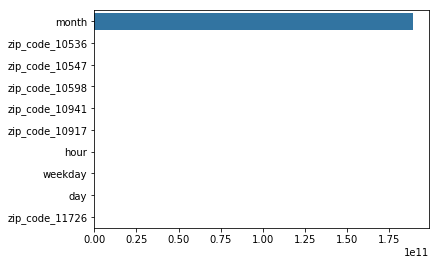

In [53]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index)